## Working with data for an ETF based on S&P 500 stock index

### Learning Objectives:

    how to generate trading signals (market positionings) in vectorized fashion
    how to backtest a formalized strategy based on the market log returns in vectorized fashion
    how to calculate and visualize the cumulative returns of trading strategies
    how to calculate annualized returns and volatilities for trading strategies

These are fundamentally important concepts in systematic (algorithmic) trading.

In [93]:
import numpy as np
import pandas as pd
from pandas_datareader import data as web
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
symbol = 'AAPL'
stock_data = web.DataReader(symbol, data_source='google', start='2005-1-1')

In [94]:
stock_data.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2017-10-09,155.81,156.73,155.48,155.84,16262923
2017-10-10,156.06,158.00,155.10,155.90,15617014
2017-10-11,155.97,156.98,155.75,156.55,16905640
2017-10-12,156.35,157.37,155.73,156.00,16125054
2017-10-13,156.73,157.28,156.41,156.99,16394188


In [95]:
stock_data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2016-10-18,118.18,118.21,117.45,117.47,24553478
2016-10-19,117.25,117.76,113.80,117.12,20034594
2016-10-20,116.86,117.38,116.33,117.06,24125801
2016-10-21,116.81,116.91,116.28,116.60,23192665
2016-10-24,117.10,117.74,117.00,117.65,23538673


## Generating a trading strategy

    We want to implement a trading strategy based on simple moving averages (SMA). 
    We work with two SMAs:
        short-term SMA over 42 days (SMA42)
        long-term SMA over 252 days (SMA252)
    We distinguish two constellations:
        SMA42 > SMA252: buy signal, being long the market
        SMA42 < SMA252: sell signal, being short the market

In [96]:
stock_data['SMA42'] = stock_data['Close'].rolling(window=42).mean()
stock_data['SMA252'] = stock_data['Close'].rolling(window=252).mean()
#stock_data.dropna(inplace=True)  # drop rows with NaN values

In [97]:
stock_data.tail()

,Open,High,Low,Close,Volume,SMA42,SMA252
Date,,,,,,,
2017-10-09,155.81,156.73,155.48,155.84,16262923,158.068095,NaN
2017-10-10,156.06,158.00,155.10,155.90,15617014,158.081905,NaN
2017-10-11,155.97,156.98,155.75,156.55,16905640,158.059762,NaN
2017-10-12,156.35,157.37,155.73,156.00,16125054,157.968095,NaN
2017-10-13,156.73,157.28,156.41,156.99,16394188,157.858333,NaN


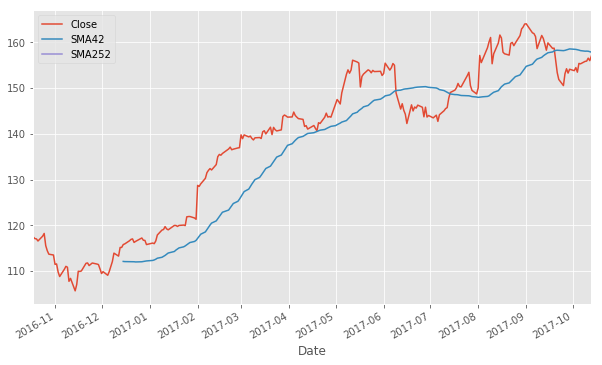

In [98]:
#In graphical terms, we want to be long in the market whenever the SMA42 line is above the SMA252 line and vice versa.
stock_data[['Close', 'SMA42', 'SMA252']].plot(figsize=(10, 6))

In [51]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2016-10-17 to 2017-10-13
Data columns (total 7 columns):
Open      250 non-null float64
High      250 non-null float64
Low       250 non-null float64
Close     251 non-null float64
Volume    251 non-null int64
SMA42     210 non-null float64
SMA252    0 non-null float64
dtypes: float64(6), int64(1)
memory usage: 15.7 KB


In [52]:
#This needs to be formalized for the calculations to come. 
#We represent "being long the market" by 1 and "being short the market" by -1.

#vectorized evaluation of the trading condition/signal generation
stock_data['position'] = np.where(stock_data['SMA42'] > stock_data['SMA252'], 1, -1)

(-1.1, 1.1)

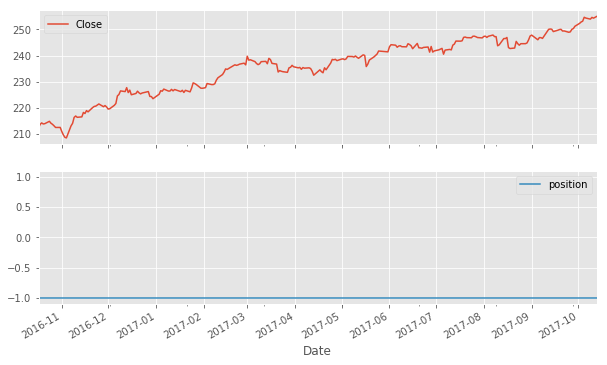

In [53]:
#Let us visualize the positions resulting from the signal. We start with a long position, do several re-positionings and end with a short position.
stock_data[['Close', 'position']].plot(subplots=True, figsize=(10, 6))
plt.ylim(-1.1, 1.1)  # adjust y-axis limits

    Let us calculate the log returns as in the first module. 
    These are needed to judge the performance, i.e. to backtest, our SMA-based trading strategy. 
    We call the column market since these are the market returns.

In [54]:
# vectorized calculation of log returns
stock_data['market'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))

Next, we can use the market returns to derive the strategy returns in vectorized fashion. Note the shift of the position column by one day, i.e. we have entered/maintained a position yesterday and today's returns. It now becomes clear, why 1 represents a long position and -1 a short position: we get the market return when we are long and -1 times the market return when we are short. All this makes obviously a number of simplifying assumptions (e.g. no transaction costs).

In [55]:
# vectorized calculation of strategy returns
stock_data['strategy'] = stock_data['position'].shift(1) * stock_data['market']

Next, let us calculate the cumulative returns of the market vs. the trading strategy. This is straightforward since we work with log returns. We first calculate the cumulative sums (cumsum) and the apply the exponential function (np.exp) to the respective time series.

In [56]:
stock_data[['market', 'strategy']].cumsum().apply(np.exp).tail()

,market,strategy
Date,,
2017-10-09,1.195734,0.836306
2017-10-10,1.198889,0.834106
2017-10-11,1.197476,0.835090
2017-10-12,1.198983,0.834040
2017-10-13,1.200443,0.833026


And the cumulative market vs. strategy returns visualized. As the numbers and the plot suggest, the strategy in this case outperforms the market by a considerable margin.

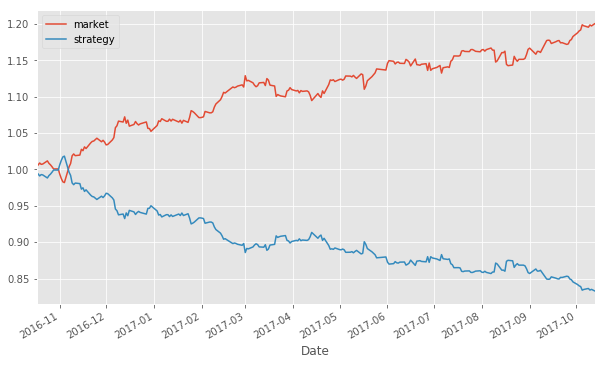

In [57]:
stock_data[['market', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));

### Final consideration: 
    what about the relation between risk & return? Let us quickly do the math. The annualized return of the strategy is obviously higher that from the market ...

In [58]:
arets = stock_data[['market', 'strategy']].mean() * 252  # annualized returns
arets

market      0.184152
strategy   -0.184152
dtype: float64


    ... while the annualized volatility is more or less the same. The higher returns do not lead to higher risk in this case.

In [59]:
astds = stock_data[['market', 'strategy']].std() * 252 ** 0.5  # annualized volatility
astds

market      0.074252
strategy    0.074252
dtype: float64